In [1]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import torch
import msBO
from msBO import plot_msGP_over_states

In [2]:
n_control = 2
n_obj = 4
n_state_PV = 2
n_state = 3

control_CSETs = [f'PSC{i}:I_CSET' for i in range(n_control)]
control_RDs = [f'PSC{i}:I_RD' for i in range(n_control)]
control_tols = [0.1]*len(control_CSETs)
control_min  = [0.0]*len(control_CSETs)
control_max  = [1.0]*len(control_CSETs)
state_CSETs  = [f'SLIT{i}:POS_CSET' for i in range(n_state_PV)]
state_RDs  = [f'SLIT{i}:POS_RD' for i in range(n_state_PV)]
state_tols   = [0.1]*len(state_CSETs)
state_vals   = [[i]*n_state_PV for i in range(n_state)]
state_names  = None
objective_PVs= [f'BPM{i}:XPOS_RD' for i in range(n_obj)]
monitor_PVs  = []

In [3]:
vm = msBO.virtual_machineIO.VM( 
    control_CSETs = control_CSETs + state_CSETs,
    control_RDs = control_RDs + state_RDs,
    monitor_PVs= objective_PVs + monitor_PVs,
    control_min= control_min + [0]*n_state_PV,
    control_max= control_max + [n_state-1]*n_state_PV,
)

machineIO = msBO.construct_machineIO.construct_machineIO(
    virtual_machineIO=vm, 
    set_manually=False)

In [4]:
# av,df = machineIO.fetch_data(objective_PVs)
# df

In [5]:
class objective_constructor:
    def __init__(self, n_obj=None, y_tol=None):
        if not isinstance(y_tol,torch.Tensor):
            self.y_tol = torch.tensor(y_tol)
        else:
            self.y_tol = y_tol

    def __call__(self, y):
        # Define shape_padding based on the dimensions of y, with '1's for broadcasting
        shape_padding = tuple(1 for _ in range(y.ndim - 1))  # y must be shape of (*, n_state, n_obj)
        obj = torch.mean(torch.std(y / self.y_tol.view(*shape_padding, -1), dim=-2), dim=-1)
        return obj

multi_state_objective_fn = objective_constructor(y_tol = [1]*n_obj)

In [6]:
msbo = msBO.MultiStateBO(
    machineIO,
    multi_state_objective_fn = multi_state_objective_fn,
    objective_PVs = objective_PVs,
    control_CSETs = control_CSETs,
    control_RDs   = control_RDs,
    control_tols  = control_tols,
    control_min   = control_min,
    control_max   = control_max,
    state_CSETs   = state_CSETs,
    state_RDs     = state_RDs,
    state_tols    = state_tols,
    state_vals    = state_vals,
    state_names   = state_names,
    monitor_PVs   = monitor_PVs,
    local_optimization = False,
    local_bound_size   = None
)

In [7]:
msbo.init(8)

In [19]:
import time
import torch
import botorch
from botorch.models import MultiTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood

def benchmark_optimizer(optimizer=None, scipy_options=None, optimizer_options=None, epochs=100):
    train_X = msbo.msGP.train_X
    train_Y = msbo.msGP.train_Y
    model = MultiTaskGP(
        train_X, 
        train_Y, 
        task_feature=-1,
        input_transform=botorch.models.transforms.input.Normalize(train_X.shape[1] - 1, 
                                                                  indices=list(range(train_X.shape[1] - 1))),
        outcome_transform=botorch.models.transforms.outcome.Standardize(1),
    )
    print(model.training)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    history = []
    
    # Start timer
    model.train()        
    with torch.no_grad():
        model_output = model(*model.train_inputs)
        log_likelihood = mll(
            model_output,
            model.train_targets,
            *(model.transform_inputs(X=t_in) for t_in in model.train_inputs),
        )
        loss = -log_likelihood.mean()
        history.append(loss.item())
        
    start_time = time.time()
    if optimizer is None:
        # Use default SciPy optimizer
        fit_gpytorch_mll(mll, options=scipy_options)
        print('after_fit_gpytorch_mll',model.training)
    else:
        # Use PyTorch optimizer (e.g., Adam) with manual optimization loop
        opt = optimizer(model.parameters(), **optimizer_options)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, 
                                                        max_lr=optimizer_options['lr'],
                                                        div_factor=2.5,
                                                        pct_start=0.1, 
                                                        final_div_factor=5,
                                                        epochs=epochs, steps_per_epoch=1)
        
        for _ in range(epochs):  # Number of iterations
            opt.zero_grad()
            model_output = model(*model.train_inputs)
            log_likelihood = mll(
                model_output,
                model.train_targets,
                *(model.transform_inputs(X=t_in) for t_in in model.train_inputs),
            )
            loss = -log_likelihood.mean()
            loss.backward()
            opt.step()
            scheduler.step()
            history.append(loss.item())
    
    # End timer
    end_time = time.time()
    # Evaluate final loss (Negative marginal log likelihood)
    fitting_time = end_time - start_time
    model.train()
    with torch.no_grad():
        model_output = model(*model.train_inputs)
        log_likelihood = mll(
            model_output,
            model.train_targets,
            *(model.transform_inputs(X=t_in) for t_in in model.train_inputs),
        )
        loss = -log_likelihood.mean()
        history.append(loss.item())
    model.eval()    
    return model, fitting_time, history

True
after_fit_gpytorch_mll False


87.55373334884644

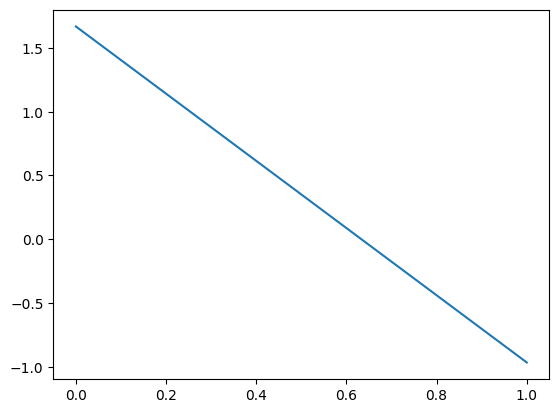

In [12]:
model, fitting_time, history = benchmark_optimizer()
plt.plot(history)
fitting_time

True


1.3004555702209473

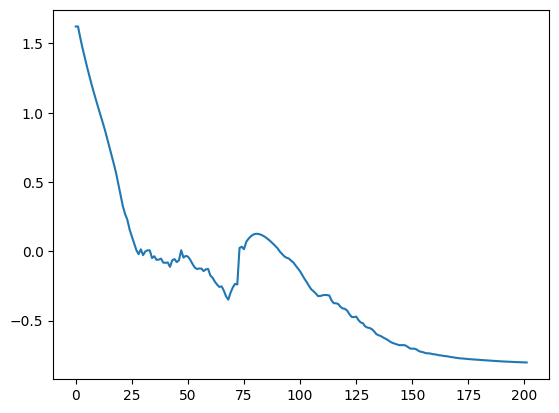

In [21]:
# Run the benchmark with Adam optimizer
model, fitting_time, history = benchmark_optimizer(optimizer=torch.optim.Adam, optimizer_options={"lr": 0.2},epochs=200)
plt.plot(history)
fitting_time